In [1]:
from elk.extraction import extract, Extract, extract_hiddens

In [2]:
df = extract(Extract("allenai/unifiedqa-t5-base", ("adzcai/genealogy_synthetic_v3",), use_encoder_states=True, token_loc='first'))
df = list(df)

Found cached dataset parquet (/home/ec2-user/.cache/huggingface/datasets/adzcai___parquet/adzcai--genealogy_synthetic_v3-5d84a0041cf3f45e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/ec2-user/.cache/huggingface/datasets/adzcai___parquet/adzcai--genealogy_synthetic_v3-5d84a0041cf3f45e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-1cef9e4ac338ad31.arrow


Using 1 variants of each prompt
No label column found, not balancing


In [ ]:
import pickle
with open('genealogy_synthetic_v3.pkl', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# do logistic regression with scikit-learn
from sklearn.linear_model import LogisticRegression
from elk.utils.typing import int16_to_float32, float32_to_int16
import torch

In [37]:
lr = LogisticRegression(max_iter=1000)

In [44]:
accs = {}

for layer in range(1, 13):
    xs = []
    for i in range(len(df)):
        xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 0]))
        xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 1]))
        xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 2]))
        xs.append(int16_to_float32(df[i][f'hidden_{layer}'][:, 3]))
    xs = torch.cat(xs)
    ys = torch.tensor([1, 0, 0, 0] * len(df))
    lr.fit(xs, ys)
    lr_outputs = lr.predict_proba(xs)[:, 1]
    accs[layer] = ((lr_outputs[0::4] > lr_outputs[1::4]) & (lr_outputs[0::4] > lr_outputs[2::4]) & (lr_outputs[0::4] > lr_outputs[3::4])).mean()

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

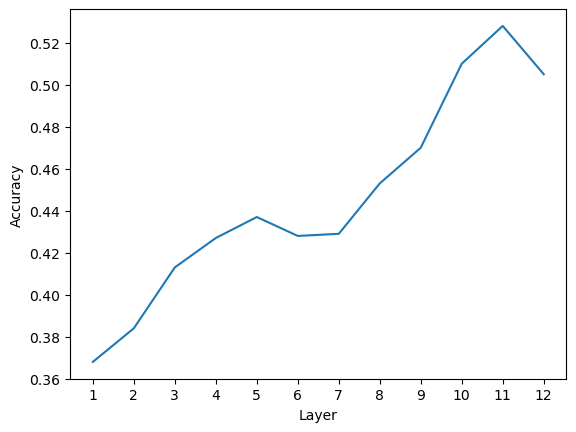

In [45]:
# plot accs

import matplotlib.pyplot as plt
import numpy as np

plt.plot(list(accs.keys()), list(accs.values()))
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 13, 1))
plt.show()


In [40]:
bin_accs = accs

In [33]:
# run the logistic regression
lr.fit(xs, ys)


/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
# get lr_weights
lr_weights = lr.coef_
# print(lr_weights)

# get lr outputs
lr_outputs = lr.predict_proba(xs)[:, 1]

[[-7.56410215e-03  2.46181307e-03  2.89032328e-03  6.57961309e-03
   1.92577129e-03 -2.16394606e-03 -2.00355915e-04  1.38041745e-03
   2.44840635e-03  6.06146118e-04  4.50988587e-03 -2.45091774e-04
   4.88280796e-03 -2.57679306e-05 -8.51044581e-03  1.80875664e-03
  -1.44344024e-03 -6.35692863e-04 -5.35123258e-03 -6.46876626e-03
  -5.93780516e-03  1.27994680e-03  3.38055031e-03  1.38369939e-03
   1.34569272e-03 -6.39005201e-04 -1.22644027e-03 -1.27934381e-03
  -8.26601900e-03 -3.20612631e-04 -2.28347455e-03 -5.39770008e-03
  -2.91796897e-04 -7.44981708e-04 -1.99224642e-03  3.39101845e-03
   3.62276028e-03  1.32355981e-03  5.84027735e-03  3.12458371e-03
   1.87926274e-03  9.54984427e-04  7.31793749e-04  2.25423550e-03
   6.07677044e-04  2.36884223e-03 -2.50755765e-03  5.00739552e-03
  -6.16798820e-03 -1.80774193e-04  3.20285463e-03  7.33254508e-03
   3.42593572e-03 -5.88015948e-03 -5.39474469e-03  1.17813820e-03
   7.04185818e-04  2.57550375e-03  3.59663006e-03 -4.09027541e-03
   3.82412

In [35]:
sum(lr_outputs[0::2] > lr_outputs[1::2])

737